Imports

In [5]:
from ultralytics import YOLO
import os
import yaml
from pathlib import Path

print("Ultralytics version imported OK.")

Ultralytics version imported OK.


Point to your dataset

In [2]:
DATA_YAML = "/home/talha/projects/waterLevel_YOLO/augmentedDataSet/data.yaml"  # <-- change this

DATA_YAML = Path(DATA_YAML)

assert DATA_YAML.exists(), f"data.yaml not found at: {DATA_YAML}"

with open(DATA_YAML, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg

{'train': 'train/images',
 'val': 'valid/images',
 'test': 'test/images',
 'nc': 12,
 'names': ['0.2',
  '0.3',
  '0.4',
  '1',
  '1.1',
  '1.2',
  '1.3',
  '1.5',
  '2.1',
  '2.3',
  'Water Level',
  'staff gauge'],
 'roboflow': {'workspace': 'watersegmentation-zsbtl',
  'project': 'my-first-project-q9p6z',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/watersegmentation-zsbtl/my-first-project-q9p6z/dataset/1'}}

Quick sanity check on images/labels

In [3]:
root = DATA_YAML.parent  # directory containing data.yaml

train_images = root / data_cfg["train"]
val_images   = root / data_cfg["val"]

print("Root:", root)
print("Train images path:", train_images)
print("Val images path:", val_images)

print("\nExists?")
print("train_images:", train_images.exists())
print("val_images:", val_images.exists())

print("\nSample train images:")
if train_images.exists():
    for i, name in enumerate(os.listdir(train_images)):
        print(" ", name)
        if i >= 4:  # show first 5
            break


Root: /home/talha/projects/waterLevel_YOLO/augmentedDataSet
Train images path: /home/talha/projects/waterLevel_YOLO/augmentedDataSet/train/images
Val images path: /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images

Exists?
train_images: True
val_images: True

Sample train images:
  IMG_4113_JPG.rf.baabf7420f65cd2f5125e310f81acdd3.jpg
  IMG_4225_JPG.rf.d219d67f313f8799dfdc08e3930a69be.jpg
  IMG_4063_JPG.rf.36320faf2ae48f8b73c42e6f1ca69f3e.jpg
  IMG_4067_JPG.rf.6253fb2a9cdc087ad7ebe7f94f98f082.jpg
  IMG_4211_JPG.rf.a752ae83b6e8342a2d1ab1e382f5e820.jpg


Train YOLOv8 on water-level dataset

In [ ]:
# Load pretrained YOLOv8 model (nano version)
model = YOLO("yolov8n.pt")  # or "yolov8s.pt" for better accuracy, slower

results = model.train(
    data=str(DATA_YAML),        # path to data.yaml
    epochs=50,                  # adjust as needed
    imgsz=640,                  # you can drop to 512 for speed
    batch=8,                    # keep small on CPU
    patience=20,                # early stopping
    project="runs_waterlevel",  # folder for all runs
    name="yolov8n_waterlevel"   # experiment name
)

results

Ultralytics 8.3.233 🚀 Python-3.12.0 torch-2.9.1+cu128 CPU (13th Gen Intel Core i7-13700K)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/talha/projects/waterLevel_YOLO/augmentedDataSet/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_waterlevel, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc9ca824470>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0

Validation Inference

In [9]:
# Load best model after training
exp_dir = Path("runs_waterlevel") / "yolov8n_waterlevel"
best_weights = exp_dir / "weights" / "best.pt"

assert best_weights.exists(), f"best.pt not found at {best_weights}"

model = YOLO(str(best_weights))

# Use the same val folder as in data.yaml
val_folder = root / data_cfg["val"]

results = model.predict(
    source=str(val_folder),   # folder of images
    save=True,                # save images with predictions
    project="runs_waterlevel",
    name="predictions_val",   # results in runs_waterlevel/predictions_val
    conf=0.25,                # confidence threshold
    imgsz=640
)

print("Done! Check: runs_waterlevel/predictions_val")



image 1/24 /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images/IMG_4035_JPG.rf.16e665c1e069f54edc83f2238d708e78.jpg: 640x576 1 staff gauge, 29.7ms
image 2/24 /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images/IMG_4047_JPG.rf.5d4645f06fa63d93b92bb90ff19c21bb.jpg: 640x576 1 1.1, 1 staff gauge, 24.2ms
image 3/24 /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images/IMG_4053_JPG.rf.890d9588dc67104cf2fcb51e22fd6230.jpg: 640x576 1 1.2, 1 1.3, 1 staff gauge, 24.5ms
image 4/24 /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images/IMG_4057_JPG.rf.50adbbb67bdbdf9caf9c1c86b1c9b785.jpg: 640x576 1 1.2, 1 staff gauge, 24.2ms
image 5/24 /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images/IMG_4065_JPG.rf.ccde114ad2da86436489909b918c5c8b.jpg: 640x576 1 1.2, 1 staff gauge, 24.2ms
image 6/24 /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images/IMG_4070_JPG.rf.ce4eac12867ad1e586784727de430830.jpg: 640x576 1 1, 1 staff g

IMG_4035_JPG.rf.16e665c1e069f54edc83f2238d708e78.jpg


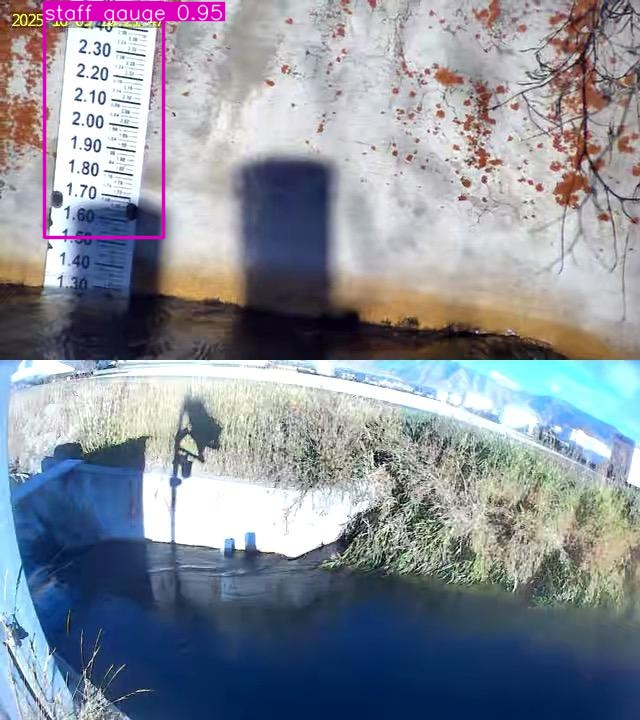

IMG_4047_JPG.rf.5d4645f06fa63d93b92bb90ff19c21bb.jpg


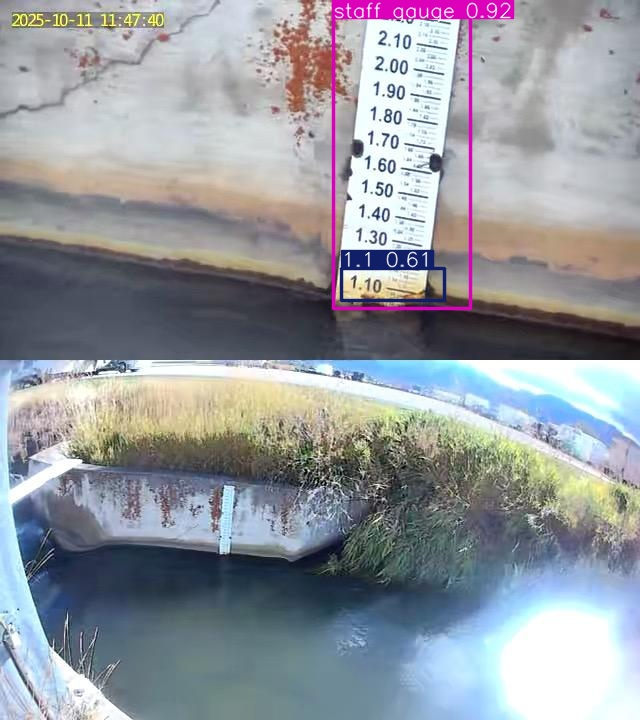

IMG_4053_JPG.rf.890d9588dc67104cf2fcb51e22fd6230.jpg


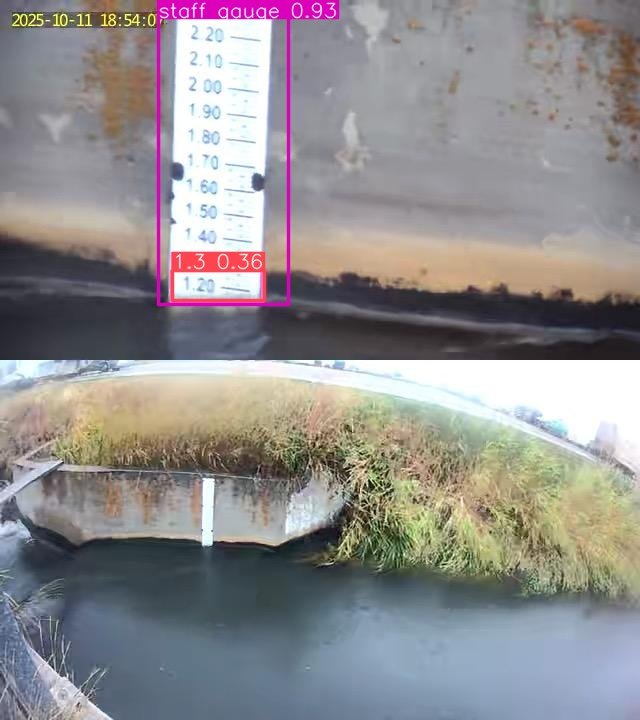

IMG_4057_JPG.rf.50adbbb67bdbdf9caf9c1c86b1c9b785.jpg


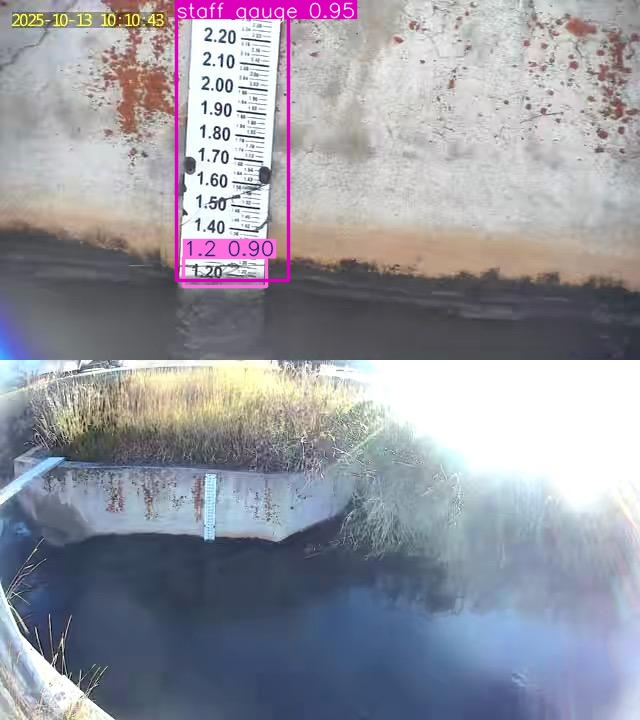

IMG_4065_JPG.rf.ccde114ad2da86436489909b918c5c8b.jpg


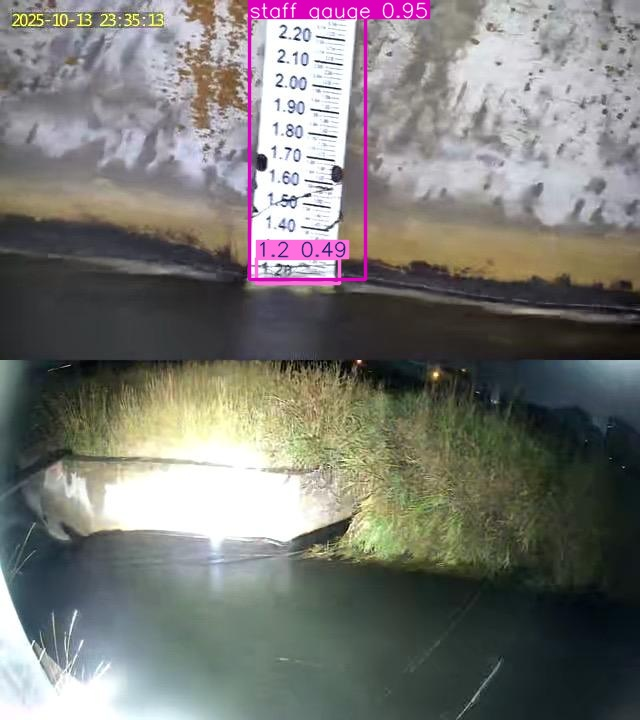

In [10]:
from IPython.display import Image, display
pred_dir = Path("runs_waterlevel") / "predictions_val"

for name in sorted(os.listdir(pred_dir))[:5]:
    print(name)
    display(Image(filename=str(pred_dir / name)))


In [11]:
model = YOLO(str(best_weights))

sample_img = list(val_folder.iterdir())[0]  # first val image
print("Running on:", sample_img)

results = model.predict(source=str(sample_img), save=False, conf=0.25)

for r in results:
    boxes = r.boxes
    print(f"Number of detections: {len(boxes)}")
    for box in boxes:
        cls_id = int(box.cls[0].item())
        conf = float(box.conf[0].item())
        x1, y1, x2, y2 = box.xyxy[0].tolist()

        print(f"class={cls_id}, conf={conf:.2f}, box=({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")


Running on: /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images/IMG_4189_JPG.rf.891b6801838a5c3a402995ccd77c8090.jpg

image 1/1 /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/images/IMG_4189_JPG.rf.891b6801838a5c3a402995ccd77c8090.jpg: 640x576 1 0.3, 1 staff gauge, 22.8ms
Speed: 1.1ms preprocess, 22.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 576)
Number of detections: 2
class=11, conf=0.96, box=(286.4, 0.0, 402.6, 217.2)
class=1, conf=0.43, box=(297.9, 180.8, 384.8, 208.7)


Explicit Validation Set Matrices

In [12]:
# Path to best weights from your training run
exp_dir = Path("runs_waterlevel") / "yolov8n_waterlevel"   # change if you used a different name
best_weights = exp_dir / "weights" / "best.pt"

assert best_weights.exists(), f"best.pt not found at {best_weights}"

model = YOLO(str(best_weights))

val_metrics = model.val(
    data=str(DATA_YAML),  # same data.yaml
    split="val"           # 🔹 use validation split
)

val_metrics


Ultralytics 8.3.233 🚀 Python-3.12.0 torch-2.9.1+cu128 CPU (13th Gen Intel Core i7-13700K)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3122.5±730.8 MB/s, size: 63.0 KB)
val: Scanning /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 93.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 3.7it/s 0.5s0.9s
                   all         24         72      0.798      0.847       0.78      0.419
                   0.2          5          5      0.545          1      0.779      0.417
                   0.3          5          5          1      0.929      0.995      0.542
                     1          7          7      0.779          1      0.978      0.369
                   1.1          3          3          1      0.997      0.995       0.55
      

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc9bc0da570>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0

In [28]:
from IPython.display import Image, HTML, display

pngs = [f for f in os.listdir(exp_dir) if f.endswith(".png")]

per_row = 4
width = 250  # adjust size

rows = []
for i in range(0, len(pngs), per_row):
    row = pngs[i:i+per_row]
    html = "".join(
        f"<img src='{exp_dir/f}' width='{width}' style='margin-right:10px; margin-bottom:10px;' />"
        for f in row
    )
    rows.append(f"<div style='display:flex;'>{html}</div>")

display(HTML("".join(rows)))


# Overall performance

mAP@0.5 = 0.78 → solid

mAP@0.5–0.95 = 0.42 → expected for a small dataset

Precision ≈ 0.80

Recall ≈ 0.85

This is very good for a first run, especially on CPU and with a very small YOLO model (yolov8n).

# Class-wise behavior

Strong classes

1, 1.1, 1.2, 0.3 → ~0.98–1.00 mAP
Your model easily recognizes them.

Weak classes

Water Level

1.3

0.4

Some rare values

Reason: They appear fewer times, so model didn’t learn them strongly.

Staff gauge (main object) → mAP 0.995

This is excellent — YOLO detects the gauge reliably.

In [29]:
# Load nano best weights (same as in your snippet)
exp_dir_n = Path("runs_waterlevel") / "yolov8n_waterlevel"
best_weights_n = exp_dir_n / "weights" / "best.pt"

assert best_weights_n.exists(), f"best.pt not found at {best_weights_n}"

model_n = YOLO(str(best_weights_n))

# 🔹 Validation metrics for nano
val_metrics_n = model_n.val(
    data=str(DATA_YAML),   # same data.yaml you used for small/large
    split="val"
)

print("YOLOv8n – VAL metrics:")
for k, v in val_metrics_n.results_dict.items():
    print(f"{k}: {v}")


Ultralytics 8.3.233 🚀 Python-3.12.0 torch-2.9.1+cu128 CPU (13th Gen Intel Core i7-13700K)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3017.4±810.2 MB/s, size: 66.9 KB)
val: Scanning /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 60.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.1it/s 0.5s0.9s
                   all         24         72      0.798      0.847       0.78      0.419
                   0.2          5          5      0.545          1      0.779      0.417
                   0.3          5          5          1      0.929      0.995      0.542
                     1          7          7      0.779          1      0.978      0.369
                   1.1          3          3          1      0.997      0.995       0.55
      

In [30]:
# 🔹 Test metrics for nano
test_metrics_n = model_n.val(
    data=str(DATA_YAML),
    split="test"
)

print("YOLOv8n – TEST metrics:")
for k, v in test_metrics_n.results_dict.items():
    print(f"{k}: {v}")


Ultralytics 8.3.233 🚀 Python-3.12.0 torch-2.9.1+cu128 CPU (13th Gen Intel Core i7-13700K)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3303.0±1232.1 MB/s, size: 71.3 KB)
val: Scanning /home/talha/projects/waterLevel_YOLO/augmentedDataSet/test/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 142.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 3.8it/s 0.5s1.0s
                   all         24         72      0.685      0.806      0.822       0.42
                   0.2          3          3      0.787          1      0.995      0.392
                   0.3          3          3      0.841          1      0.995      0.485
                     1          8          8      0.658          1      0.874      0.426
                   1.1          4          4      0.721        0.5      0.788      0.414
                   1.2          4          4      0.605       0.75      0.756      0.

Better Yolo for More accuracy

In [14]:
# Larger model: YOLOv8s (small, but much stronger than nano)
model_s = YOLO("yolov8s.pt")

results_s = model_s.train(
    data=str(DATA_YAML),          # same data.yaml
    epochs=200,                   # more training
    imgsz=640,                    # keep high for detail on small numbers
    batch=8,                      # you can even try 16 if RAM allows
    patience=80,                  # let it run long before early-stopping
    project="runs_waterlevel",    # same root
    name="yolov8s_waterlevel",    # NEW experiment name
    device="cpu"                  # we don't care it's CPU, just accurate
)

results_s


New https://pypi.org/project/ultralytics/8.3.234 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.233 🚀 Python-3.12.0 torch-2.9.1+cu128 CPU (13th Gen Intel Core i7-13700K)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/talha/projects/waterLevel_YOLO/augmentedDataSet/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc9ca7370b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0

Load the trained YOLOv8s model

In [16]:
exp_dir_s = Path("runs_waterlevel") / "yolov8s_waterlevel"
best_weights_s = exp_dir_s / "weights" / "best.pt"

assert best_weights_s.exists(), f"best.pt not found at {best_weights_s}"

model_s = YOLO(str(best_weights_s))
print("Loaded:", best_weights_s)


Loaded: runs_waterlevel/yolov8s_waterlevel/weights/best.pt


In [17]:
val_metrics_s = model_s.val(
    data=str(DATA_YAML),
    split="val"
)

val_metrics_s

Ultralytics 8.3.233 🚀 Python-3.12.0 torch-2.9.1+cu128 CPU (13th Gen Intel Core i7-13700K)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3507.5±708.1 MB/s, size: 67.0 KB)
val: Scanning /home/talha/projects/waterLevel_YOLO/augmentedDataSet/valid/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 80.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s2.2s
                   all         24         72      0.632      0.762      0.786      0.435
                   0.2          5          5      0.533          1      0.938      0.507
                   0.3          5          5      0.791        0.6      0.928      0.468
                     1          7          7      0.712          1      0.978      0.386
                   1.1          3          3      0.953          1      0.995      0.685
    

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fca4e6b9580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0

In [18]:
rd_val = val_metrics_s.results_dict
for k, v in rd_val.items():
    print(f"{k}: {v}")


metrics/precision(B): 0.632075674600405
metrics/recall(B): 0.762438245623785
metrics/mAP50(B): 0.7858518299214401
metrics/mAP50-95(B): 0.43521524480866436
fitness: 0.43521524480866436


In [19]:
test_metrics_s = model_s.val(
    data=str(DATA_YAML),
    split="test"
)

test_metrics_s


Ultralytics 8.3.233 🚀 Python-3.12.0 torch-2.9.1+cu128 CPU (13th Gen Intel Core i7-13700K)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3793.2±1510.5 MB/s, size: 80.4 KB)
val: Scanning /home/talha/projects/waterLevel_YOLO/augmentedDataSet/test/labels... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 3.5Kit/s 0.0s
val: New cache created: /home/talha/projects/waterLevel_YOLO/augmentedDataSet/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.0it/s 1.0s2.2s
                   all         24         72      0.812       0.79      0.822      0.423
                   0.2          3          3          1      0.898      0.995      0.458
                   0.3          3          3      0.672          1      0.995      0.572
                     1          8          8      0.885      0.965      0.939      0.465
                   1.1          4          4      0.443        0.5      0.691      0.4

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  8, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc9c8e4f0b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046, 

In [20]:
rd_test = test_metrics_s.results_dict
for k, v in rd_test.items():
    print(f"{k}: {v}")


metrics/precision(B): 0.8122123110136968
metrics/recall(B): 0.7903800427483265
metrics/mAP50(B): 0.8216025584385211
metrics/mAP50-95(B): 0.4229268659557622
fitness: 0.4229268659557622


We trained a YOLOv8-S model on our annotated water-level dataset and evaluated it on a held-out test set. The model achieved a precision of 0.812 and recall of 0.790, demonstrating reliable detection of gauge markings and water-level indicators. The overall detection accuracy reached 0.822 mAP@50, with 0.423 mAP@50–95 at stricter IoU thresholds. These results show that YOLOv8-S is effective at locating the staff gauge and reading water-level numerals, with strong general performance given the small dataset size and fine-grained nature of the labels.

In [27]:
from IPython.display import Image, HTML, display

save_dir = Path(test_metrics_s.save_dir)
pngs = [f for f in os.listdir(save_dir) if f.endswith(".png")]

# how many per row
per_row = 4
width = 250  # image size

rows = []
for i in range(0, len(pngs), per_row):
    row_imgs = pngs[i:i+per_row]
    html = "".join(
        f"<img src='{save_dir/f}' width='{width}' style='margin-right:8px;' />"
        for f in row_imgs
    )
    rows.append(f"<div style='display:flex; margin-bottom:10px'>{html}</div>")

display(HTML("".join(rows)))
